# 1. References

Title: Multi-Label Classification(Blog Tags Prediction)using NLP

Link: https://medium.com/coinmonks/multi-label-classification-blog-tags-prediction-using-nlp-b0b5ee6686fc

Naive approach is to do x -> y1, x -> y1, y2, x -> y1, y2, y3

# 2. Imports

In [1]:
import pandas as pd

# 3. Creation of a valid dataframe - one hot encoding style

In [2]:
file_name = 'TED_Talks_by_ID_plus-transcripts-and-LIWC-and-MFT-plus-views.csv'
# file_name = 'TED_Transcripts_short.csv'
df = pd.read_csv('../owentemple-ted-talks-complete-list/{}'.format(file_name))
df.head()

,id,speaker,headline,URL,description,transcript_URL,month_filmed,year_filmed,event,duration,...,harm_vice,fairness_virtue,fairness_vice,ingroup_virtue,ingroup_vice,authority_virtue,authority_vice,purity_virtue,purity_vice,morality_general
0,1,Al Gore,Averting the climate crisis,http://www.ted.com/talks/view/id/1,With the same humor and humanity he exuded in ...,http://www.ted.com/talks/view/id/1/transcript?...,2,2006,TED2006,0:16:17,...,0.04,0.00,0.00,0.48,0.00,0.22,0.0,0.00,0.00,0.22
1,2,Amy Smith,Simple designs to save a life,http://www.ted.com/talks/view/id/2,Fumes from indoor cooking fires kill more than...,http://www.ted.com/talks/view/id/2/transcript?...,2,2006,TED2006,0:15:06,...,0.04,0.00,0.00,0.30,0.00,0.11,0.0,0.11,0.04,0.15
2,3,Ashraf Ghani,How to rebuild a broken state,http://www.ted.com/talks/view/id/3,Ashraf Ghani's passionate and powerful 10-minu...,http://www.ted.com/talks/view/id/3/transcript?...,7,2005,TEDGlobal 2005,0:18:45,...,0.12,0.16,0.04,0.32,0.12,0.20,0.0,0.04,0.04,0.08
3,4,Burt Rutan,The real future of space exploration,http://www.ted.com/talks/view/id/4,"In this passionate talk, legendary spacecraft ...",http://www.ted.com/talks/view/id/4/transcript?...,2,2006,TED2006,0:19:37,...,0.19,0.00,0.00,0.19,0.00,0.10,0.0,0.00,0.00,0.16
4,5,Chris Bangle,Great cars are great art,http://www.ted.com/talks/view/id/5,American designer Chris Bangle explains his ph...,http://www.ted.com/talks/view/id/5/transcript?...,2,2002,TED2002,0:20:04,...,0.05,0.03,0.00,0.39,0.00,0.05,0.0,0.00,0.03,0.13


In [3]:
df.iloc[:,:15].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 15 columns):
id                      2475 non-null int64
speaker                 2475 non-null object
headline                2475 non-null object
URL                     2475 non-null object
description             2475 non-null object
transcript_URL          2386 non-null object
month_filmed            2475 non-null int64
year_filmed             2475 non-null int64
event                   2475 non-null object
duration                2475 non-null object
date_published          2475 non-null object
views_as_of_06162017    2474 non-null float64
tags                    2475 non-null object
transcript              2386 non-null object
notes                   4 non-null object
dtypes: float64(1), int64(3), object(11)
memory usage: 290.1+ KB


## 3.1 Remove nan transcripts

In [4]:
df = df.dropna(subset=['transcript'])
df = df.reset_index(drop=True)
df.iloc[:,:15].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 15 columns):
id                      2386 non-null int64
speaker                 2386 non-null object
headline                2386 non-null object
URL                     2386 non-null object
description             2386 non-null object
transcript_URL          2386 non-null object
month_filmed            2386 non-null int64
year_filmed             2386 non-null int64
event                   2386 non-null object
duration                2386 non-null object
date_published          2386 non-null object
views_as_of_06162017    2386 non-null float64
tags                    2386 non-null object
transcript              2386 non-null object
notes                   4 non-null object
dtypes: float64(1), int64(3), object(11)
memory usage: 279.7+ KB


## 3.2 Finding the unique tags

In [5]:
joined_tags = df['tags'].str.cat(sep=',').split(',')
all_tags = pd.Series(joined_tags).str.strip().str.lower()
all_tags = list(dict.fromkeys(all_tags))
all_tags.remove('')
print(all_tags)
print(len(all_tags))

['cars', 'alternative energy', 'culture', 'politics', 'science', 'climate change', 'environment', 'sustainability', 'global issues', 'technology', 'macarthur grant', 'simplicity', 'industrial design', 'invention', 'engineering', 'design', 'corruption', 'poverty', 'economics', 'investment', 'military', 'policy', 'global development', 'entrepreneur', 'business', 'aircraft', 'flight', 'nasa', 'rocket science', 'transportation', 'art', 'biotech', 'oceans', 'genetics', 'dna', 'biology', 'biodiversity', 'ecology', 'computers', 'software', 'interface design', 'music', 'media', 'entertainment', 'performance', 'new york', 'memory', 'interview', 'death', 'architecture', 'disaster relief', 'cities', 'urban planning', 'collaboration', 'robots', 'education', 'innovation', 'social change', 'obesity', 'disease', 'health', 'health care', 'food', 'primates', 'africa', 'animals', 'nature', 'wunderkind', 'cancer', 'creativity', 'love', 'gender', 'relationships', 'cognitive science', 'psychology', 'evolut

## 3.3 Creating a new dataframe

In [6]:
def create_one_hot_encode(df=df):
    complete_transcripts_tags = []
    for rows, value in df.iterrows():
        one_hot_encoding = [0] * 417
        transcript = [value['transcript']]
        indiv_tags = value['tags'].split(',')
        for tags in indiv_tags:
            if tags == '':
                continue
            index = all_tags.index(tags.lower().lstrip(' '))
            one_hot_encoding[index] = 1
        indiv_transcript_tags = transcript + one_hot_encoding
        complete_transcripts_tags.append(indiv_transcript_tags)
    return pd.DataFrame(complete_transcripts_tags, columns=['transcript'] + all_tags)

In [7]:
ted_tags = create_one_hot_encode()
ted_tags

,transcript,cars,alternative energy,culture,politics,science,climate change,environment,sustainability,global issues,...,anthropocene,syria,movies,ted residency,ted-ed,telescopes,ted en espanol,alzheimer's,ted en español,epidemiology
0,"0:14\r\r\rThank you so much, Chris.\rAnd it's ...",1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,"0:11\r\r\rIn terms of invention,\rI'd like to ...",0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,"0:12\r\r\rA public, Dewey long ago observed,\r...",0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,"0:11\r\r\rI want to start off by saying, Houst...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"0:12\r\r\rWhat I want to talk about is, as bac...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"0:11\r\r\rAt the break, I was asked by several...",0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"0:12\r\r\r(Music: ""The Sound of Silence,""\rSim...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"0:13\r\r\rKurt Andersen: Like many architects,...",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"0:11\r\r\rAs you pointed out, every time you c...",1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,0:11\r\r\rWith all the legitimate concerns\rab...,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# 4. Cleaning the data

In [8]:
'''
1. Numbers
2. Apostrophe
3. All punctuations
4. Weird symbols
5. Stop words
6. lemmatization
'''

import string
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from sklearn.feature_extraction import stop_words
from nltk.stem.wordnet import WordNetLemmatizer
sets=[stop_words.ENGLISH_STOP_WORDS]
sklearnStopWords = [list(x) for x in sets][0]
token=ToktokTokenizer()
lemma=WordNetLemmatizer()
stopWordList=stopwords.words('english')
stopWords = stopWordList + sklearnStopWords
stopWords = list(dict.fromkeys(stopWords))


def stopWordsRemove(text):
    wordList=[x.lower().strip() for x in token.tokenize(text)]
    removedList=[x + ' ' for x in wordList if not x in stopWords]
    text=''.join(removedList)
    return text


def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w,'v')
        listLemma.append(x)
    return text


# There is a mispelt word that needs to be replaced
ted_tags['transcript'] = ted_tags['transcript'].str.replace('\r',' ')
ted_tags['transcript'] = ted_tags['transcript'].str.replace("\'s"," is")
ted_tags['transcript'] = ted_tags['transcript'].str.replace("\'m"," am")
ted_tags['transcript'] = ted_tags['transcript'].str.replace("\'ll"," will")
ted_tags['transcript'] = ted_tags['transcript'].str.replace("Can\'t","cannot")
ted_tags['transcript'] = ted_tags['transcript'].str.replace("Sha\'t","shall not")
ted_tags['transcript'] = ted_tags['transcript'].str.replace("Won\'t","would not")
ted_tags['transcript'] = ted_tags['transcript'].str.replace("n\'t"," not")
ted_tags['transcript'] = ted_tags['transcript'].str.replace("\'ve"," have")
ted_tags['transcript'] = ted_tags['transcript'].str.replace("\'re"," are")
ted_tags['transcript'] = ted_tags['transcript'].str.replace("\'d"," would")
ted_tags['transcript'] = ted_tags['transcript'].str.replace(r"\(([^)]+)\)","")
# Deal with Mr. and Dr.
ted_tags['transcript'] = ted_tags['transcript'].str.replace("mr. ","mr")
ted_tags['transcript'] = ted_tags['transcript'].str.replace("Mr. ","mr")
ted_tags['transcript'] = ted_tags['transcript'].str.replace("dr. ","dr")
ted_tags['transcript'] = ted_tags['transcript'].str.replace("mrs. ","mrs")
ted_tags['transcript'] = ted_tags['transcript'].str.replace("Mrs. ","mrs")
ted_tags['transcript'] = ted_tags['transcript'].str.replace("Dr. ","dr")

ted_tags['transcript'] = ted_tags['transcript'].str.replace(r'\d+','')
ted_tags['transcript'] = ted_tags['transcript'].str.replace(r'<.*?>','')
for i in string.punctuation:
    if i == "'":
        ted_tags['transcript'] = ted_tags['transcript'].str.replace(i,'')
    else:
        ted_tags['transcript'] = ted_tags['transcript'].str.replace(i,' ')
ted_tags['transcript'] = ted_tags['transcript'].map(lambda com : stopWordsRemove(com))
ted_tags['transcript'] = ted_tags['transcript'].map(lambda com : lemitizeWords(com))
ted_tags['transcript'] = ted_tags['transcript'].str.replace('\s+',' ')


In [9]:
ted_tags

,transcript,cars,alternative energy,culture,politics,science,climate change,environment,sustainability,global issues,...,anthropocene,syria,movies,ted residency,ted-ed,telescopes,ted en espanol,alzheimer's,ted en español,epidemiology
0,thank chris truly great honor opportunity come...,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,terms invention like tell tale favorite projec...,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,public dewey long ago observed constituted dis...,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,want start saying houston problem entering sec...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,want talk background idea cars art actually qu...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,break asked people comments aging debate comme...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,hello voice mail old friend called tech suppor...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,kurt andersen like architects david hog limeli...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,pointed time come learn morning world experts ...,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,legitimate concerns aids avian flu hear brilli...,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


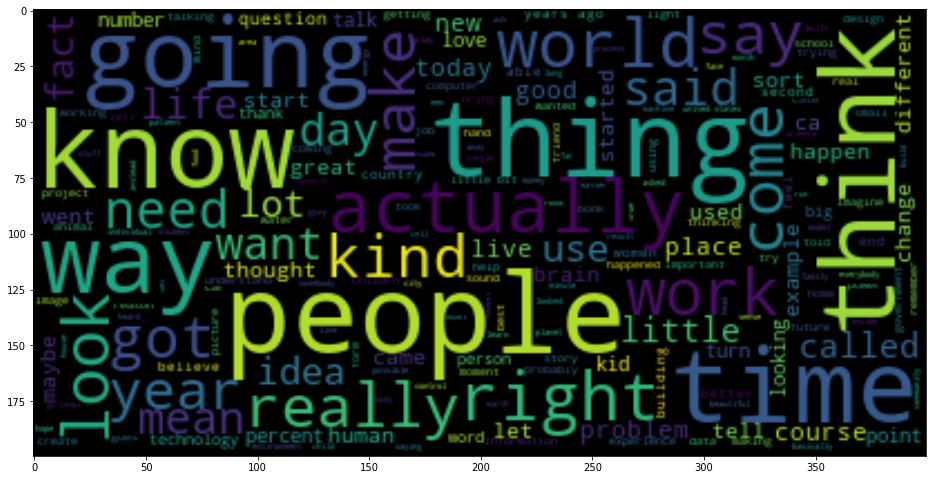

In [15]:
# !pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

totalText=''
for x in ted_tags['transcript']:
    totalText=totalText+''+x
wc=WordCloud(background_color='black',max_font_size=50).generate(totalText)
plt.figure(figsize=(16,12))
plt.imshow(wc, interpolation='bilinear')

# 5. Machine Learning part

In [16]:
x=ted_tags.iloc[:,0].values
y=ted_tags.iloc[:,1:-1].values


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
body = ted_tags.transcript
cv = CountVectorizer().fit(body)
article = pd.DataFrame(cv.transform(body).todense(),columns=cv.get_feature_names())

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfart=TfidfTransformer().fit(article)
art=pd.DataFrame(tfidfart.transform(article).todense())

In [27]:
# !pip install scikit-multilearn

# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
xtrain,xtest,ytrain,ytest=train_test_split(art,y)
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(xtrain.astype(float), ytrain.astype(float))

# predictions = classifier.predict(xtest.astype(float))
# predictions = classifier.predict_proba(xtest.astype(float))
# predictions.toarray()


In [20]:
predictions = classifier.predict(xtest.astype(float))

In [28]:
# from sklearn.metrics import accuracy_score
# accuracy_score(ytest.astype(float),predictions)

In [22]:
print(ytest)
print(ytest.sum(axis=1))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[ 5  5  4  9  3  8 19 12  5 16  6  4  5 11  4 20 13  6  3  3  6  4  3  2
 19  4  5  6  5  4  4  5  3  7  6  6  4  4  6  2  8  9  4  9 13  6  4  5
  3  9  5 13  5  6  6  3  9  6 11  5  2  7  5  8  6  3  9 15  7  4  6  4
  5 12  5  8  3  4  4  8  9  5  7  6  4 16 10  6  4 21  3 14  2 10  7 10
  4  2  5  5  6  4  7  6  6  5  6 12  5 13  4  3  6  9  3  6 13  4  6  6
 14  7  6  8  5  4  7  7  4  5  5  9  6  6 21  7  3 11 16  5 13 16  5  7
  6  9  7  5  8  6  7  4  2  4  6 21 19 12  4 12  7 15  5  7  4  5 13  4
  5 17  9  8 16  8  5  5 10  3 14  4  5  4  9  4  8  7  5 14 11  5  7  3
  8 17 16  7 12  9  3  9  9  5  5  5  7  8  4 22 13  4  8  9  6  6  9  7
  5  6  4 16 10  5  6 12  7 21  7  6 16  3 10  3 28  9  9  5 10  2 13 13
  6  6  3  9  5  2  6  4  5  3  5  6  4 12  7 29  3  7 13  3  5  8  6 18
  2  5  3  3  7  5  5  6 13  7 11  2  5  4  4 12 19  5 14  4  9 10  7  6
  7 

In [24]:
def compute_accuracy(test, predict):
    true_positive_ls = []
    true_negative_ls = []
    false_positive_ls = []
    false_negative_ls = []
    labelled_tags = 0
    # overall_correct_one = 0
    for index_pred, value_pred in enumerate(predict):
        true_positive = 0
        true_negative = 0
        false_positive = 0
        false_negative = 0
        for index_pred_indiv, value_pred_indiv in enumerate(value_pred):
            if test[index_pred][index_pred_indiv] == 1:
                labelled_tags += 1
            if value_pred_indiv == test[index_pred][index_pred_indiv]:
                if value_pred_indiv == 1:
                    # overall_correct_one += 1
                    true_positive += 1
                else:
                    true_negative += 1
            else:
                if value_pred_indiv == 1:
                    # Test is 0 but we predict 1
                    false_positive += 1
                else:
                    false_negative += 1
        true_positive_ls.append(true_positive)
        true_negative_ls.append(true_negative)
        false_positive_ls.append(false_positive)
        false_negative_ls.append(false_negative)
    return true_positive_ls, true_negative_ls, false_positive_ls, false_negative_ls
#     print(correct_one_ls)
#     print(wrong_ls)
#     print(labelled_tags)
#     print(overall_correct_one/labelled_tags)

true_positive_ls, true_negative_ls, false_positive_ls, false_negative_ls = compute_accuracy(ytest, predictions.toarray())

true_pos = sum(true_positive_ls)
true_neg = sum(true_negative_ls)
false_pos = sum(false_positive_ls)
false_neg = sum(false_negative_ls)
# print(true_pos)
# print(true_neg)
# print(false_pos)
# print(false_neg)
precision = true_pos/(true_pos + false_pos)
recall = true_pos/(true_pos + false_neg)
accuracy = (true_pos + true_neg) / (false_pos + false_neg + true_pos + true_neg)
weighted_harmonic_mean = (2 * precision * recall) / (precision + recall)
print('The precision is {}'.format(precision))
print('The recall is {}'.format(recall))
print('The accuracry (naive) is {}'.format(accuracy))
print('The weighted harmonic mean/F1 score is {}'.format(weighted_harmonic_mean))

The precision is 0.09043250327653997
The recall is 0.03076923076923077
The accuracry (naive) is 0.9769077760597861
The weighted harmonic mean/F1 score is 0.045915820994842795


In [25]:
print(predictions.toarray().sum(axis=1))
print(type(predictions))

[  1.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   1.   0.   0.
   0.   0.   3.   0.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   1.   0.   1.   0.   0.   0.   0.   0.   0.   1.   0.   0.   2.   0.
   0.   0.   0.   0.   7.   1.   1.   0.   1.   0.   0.   0.   0.   1.
   0.   0.   0.   2.   1.   0.   0.   0.   1.   0.   0.   1.   1.   0.
   0.   1.   0.   1.   0.   0.   0.   0.   0.   1.   0.   1.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   1.   2.   0.   2.
   0.   2.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
   0.   0.   0.   0.   1.   0.   1.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   4.   0.   0.   0.
   0.   0.   0.   1.   0.   1.   0.   0.   4.   2.   0.   2.   0.   0.
   0.   3.   1.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   1.
   0.   0.   0.   0.   0.   1.   2.   1.   0.   0.   1.   0.   0.   7.
   2.   0.   0.   0.   0.   2.   0.   0.   3.   0.   0.   0.   0.   0.
   0. 

# 6. Save the model

In [26]:
from joblib import dump, load
dump(classifier, 'classifier_binary_relevance.joblib') 

['classifier_binary_relevance.joblib']